### Importing Packages

In [9]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4
from netCDF4 import Dataset
import numpy  as np
import scipy
from scipy import stats

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib
import matplotlib.dates as mdates
from matplotlib.ticker import AutoMinorLocator, StrMethodFormatter
from matplotlib.pyplot import cm
from matplotlib.lines import Line2D

from gsw import p_from_z
from gsw import pot_rho_t_exact as prho

import seaborn as sns
# sns.reset_defaults()
sns.set_theme(style='darkgrid')
# sns.set_context('talk')

import datetime

from scipy import interpolate, ndimage
from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

import sys
import subprocess

from datetime import datetime, date

import glob
import os

import warnings
warnings.filterwarnings("ignore")

sys.path.append(os.path.abspath("D:/00_Masters/00_Work/"))
from Utils.inertP import *
from Utils.veldire2uv import *
from Utils.HistDir import *
from Utils.uv2veldire import *
from Utils.rmse import *

In [10]:
sns.set_theme(style='darkgrid')

### Loading database

##### Informacoes adicionais

In [11]:
Coast_angle_Corr = [-15,0,20,40,40,45] # correção para estação de salvador baseado na literatura, nao no grau calculado 
names = ['SBNT','SBJP','SBRF','SBMO','SBAR','SBSV']   

##### Dataset do ERA5

In [12]:
dsmerged = xr.open_dataset('D:/00_Masters/01_Dados/ERA5/ERA5.nc')
dsmerged = dsmerged.sel(time=slice('2014-11-25', '2019-12-31')) #Slice do tempo para validação do dados

era_SBNT = dsmerged.sel(latitude=-5.8, longitude=-35.1, method='nearest') # 2º point-5.8 -34.85
uE_SBNT = era_SBNT['u10']
vN_SBNT = era_SBNT['v10']

era_SBJP = dsmerged.sel(latitude=-7.05, longitude=-34.6, method='nearest') # 2º point-7.05 -34.35
uE_SBJP = era_SBJP['u10']
vN_SBJP = era_SBJP['v10']

era_SBRF = dsmerged.sel(latitude=-8.05, longitude=-34.6, method='nearest') # 2º point-8.05 -34.35
uE_SBRF = era_SBRF['u10']
vN_SBRF = era_SBRF['v10']

era_SBMO = dsmerged.sel(latitude=-9.55, longitude=-35.35, method='nearest') # 2º point-9.55 -35.1
uE_SBMO = era_SBMO['u10']
vN_SBMO = era_SBMO['v10']

era_SBAR = dsmerged.sel(latitude=-11.05, longitude=-36.85, method='nearest') # 2º point -11.05 -36.6
uE_SBAR = era_SBAR['u10']
vN_SBAR = era_SBAR['v10']

era_SBSV = dsmerged.sel(latitude=-13.05, longitude=-38.35, method='nearest') # 2º point -12.8/-13.05 -37.85/-38.1
uE_SBSV = era_SBSV['u10']
vN_SBSV = era_SBSV['v10']

In [13]:
# ## LOcalização automatica baseada nas estações do metar
# era_SBNT = dsmerged.sel(latitude=-5.91, longitude=-35.25, method='nearest') # 2º point-5.8 -34.85
# uE_SBNT = era_SBNT['u10']
# vN_SBNT = era_SBNT['v10']

# era_SBJP = dsmerged.sel(latitude=-7.15, longitude=-34.97, method='nearest') # 2º point-7.05 -34.35
# uE_SBJP = era_SBJP['u10']
# vN_SBJP = era_SBJP['v10']

# era_SBRF = dsmerged.sel(latitude=-8.13, longitude=-34.92, method='nearest') # 2º point-8.05 -34.35
# uE_SBRF = era_SBRF['u10']
# vN_SBRF = era_SBRF['v10']

# era_SBMO = dsmerged.sel(latitude=-9.51, longitude=-35.79, method='nearest') # 2º point-9.55 -35.1
# uE_SBMO = era_SBMO['u10']
# vN_SBMO = era_SBMO['v10']

# era_SBAR = dsmerged.sel(latitude=-10.98, longitude=-37.07, method='nearest') # 2º point -11.05 -36.6
# uE_SBAR = era_SBAR['u10']
# vN_SBAR = era_SBAR['v10']

# era_SBSV = dsmerged.sel(latitude=-12.91, longitude=-38.33, method='nearest') # 2º point -12.8 -37.85/-38.1
# uE_SBSV = era_SBSV['u10']
# vN_SBSV = era_SBSV['v10']

##### Dataset do METAR

In [14]:
Metar_describ = pd.DataFrame({'label':['SBNT','SBJP','SBRF','SBMO','SBAR','SBSV'],
                      'Latitude':[-5.91,-7.15,-8.13,-9.51,-10.98,-12.91],
                      'Longitude': [-35.25,-34.97,-34.92,-35.79,-37.07,-38.33]})

i = [0,1,2,3,4,5]
df_list =[]

for n in range(len(names)):
    df = pd.read_csv("D:/00_Masters/01_Dados/METAR/"+ names[n] +".csv",sep=',',
    index_col='times', parse_dates=True)
    df = df['2014-11-25':'2019-12-31'] # Slice do tempo para validação dos dados
    df_list.append(df)

## Analises

#### Calculo do período inericial e filtragem

In [15]:
P = []
for i in Metar_describ['Latitude']:
    P.append(inertP(lat=i))

            ERA5

In [16]:
era = {}

for n,fi,c in zip(names,P,Coast_angle_Corr):
    varU = eval('uE_{}'.format(n)).to_dataframe()
    varU = varU.rolling(str((fi*-1//24)+1)+'D',center=True).mean()
    varU = varU.resample('1D').mean()

    varN = eval('vN_{}'.format(n)).to_dataframe()
    varN = varN.rolling(str((fi*-1//24)+1)+'D',center=True).mean()
    varN = varN.resample('1D').mean()

    erat = varU
    erat['v10'] = varN['v10']
    erat['speed'], erat['direction'] = uv2veldire(erat['u10'],erat['v10'],corr_val=c)#
    erat['u'], erat['v'] = veldire2uv(erat['speed'], erat['direction']) #Replica a coluna para caso haja correção em relação a costa e ajusta nome da coluna
    
    erat['direction'] -= 180 
    erat['direction'][erat['direction']<0] += 360

    era['era_{}'.format(n)] = erat


            METAR

In [17]:
met = {}

for i,n,fi,c in zip(range(0,len(names)),names,P,Coast_angle_Corr):
    ban = df_list[i].rolling(str((fi*-1//24)+1)+'D',center=True).mean()
    ban = ban.resample('1D').mean()
    ban['direction'] = ban['direction'] - c
    ban['u'],ban['v'] = veldire2uv(ban['speed'],ban['direction'])
    ban = ban.interpolate(method='linear')
    ban['direction'] -=180
    ban['direction'][ban['direction']<0] += 360

    met['{}'.format(n)] = ban

#### FIles e Figs - Estatísticas Básicas e Correlação

            Estatísticas e Correlaçoes para periodo total

In [18]:
vars = ['speed','direction','u','v']
nam = ['Metar','ERA5']
path_output = 'D:/00_Masters/02_Resultados_Parciais/Validacao_Meteo/'


for n in names:
    schema = [met[n],era['era_{}'.format(n)]]
    f1 = open(os.path.join(path_output, './{}/'.format(n),'./Correlacoes_STATs/Stats_WND_{}.txt'.format(n)) , 'w')
    print('\n\t',n,file=f1)

    for v in vars:
        for i in range(0,len(schema)):
            print('\n',nam[i],' - Variable: ',v,file=f1)
            print(stats.describe(schema[i][v],nan_policy='omit'), ('std= '+str(np.std(schema[i][v]))),file=f1)
    f1.close()

    f2 = open(os.path.join(path_output, './{}/'.format(n),'./Correlacoes_STATs/R2_{}.txt'.format(n)) , 'w')
    R = []
    RMSE = []
    for v in vars:
        for i in range(0,len(schema)-1):
            res = stats.pearsonr(x=schema[i+1][v],y=schema[0][v])
            err = rmse(schema[i+1][v],schema[0][v])
            print('\n',' - Variable: ',v,file=f2)
            print('Pearson Corr. -', nam[i+1], nam[0],file=f2)
            print(res,file=f2)
            print('Root Mean Square Error RMSE -', nam[i+1], nam[0],file=f2)
            print(err,file=f2)

            R.append(np.round(res[0],5))
            RMSE.append(np.round(err,3))
    f2.close()

    ''' 
    FIGURA COM SeaBorn

    '''
    for ind,v in enumerate(vars):
        fig, [ax1,ax2] = plt.subplots(nrows=1, ncols=2, gridspec_kw={'width_ratios':[2,2], 'height_ratios':[1]})
        cmap = sns.color_palette(as_cmap=True)

        with sns.axes_style("darkgrid"):
            for i in range(0,len(schema)):
                ax1 = sns.kdeplot(data=schema[i][v], x = schema[i][v], fill=True, alpha=.2, linewidth=2, bw=0.2, ax=ax1)

        with sns.axes_style("darkgrid"):
            for i in range(0,len(schema)-1):
                ax2 = sns.regplot(x=schema[i+1][v], y=schema[0][v], color=cmap[i+1], fit_reg = False, ax=ax2)

        fig.subplots_adjust(wspace=0.5)
        fig.suptitle('{}'.format(n)+' - '+v.format().capitalize(),fontsize=14,y=.95)

        if str(v) == 'speed':
            unit = "[m.s$^{-1}$]"
            ax1.set_xticks(np.arange(0,12,2.5))
            ax2.set_xticks(np.arange(0,12,2.5))
            ax2.set_yticks(np.arange(0,12,2.5))
            ax1.set_ylim(0,.7)
        elif str(v) == 'direction':
            unit = "[°]"
            ax1.set_xticks(np.arange(0,360,90))
            ax2.set_xticks(np.arange(0,360,90))
            ax2.set_yticks(np.arange(0,360,90))
            ax1.set_ylim(0,0.04)
        else:
            unit = ""
            ax1.set_xticks(np.arange(-8,10,2))
            ax2.set_xticks(np.arange(-8,10,2))
            ax2.set_yticks(np.arange(-8,10,2))
            ax1.set_ylim(0,.56)

        ax1.set_xlabel(unit)
        ax2.set_xlabel('ERA5 ' + unit)
        ax2.set_ylabel('Metar ' + unit)
        
        ax1.legend(nam,fontsize=12, bbox_to_anchor = (-.2,-.18),loc='upper left', ncol=3)

        ax2.annotate('Pearson. Coef.:', fontsize=6.5,color='k',xy=(.6,.15),xycoords='axes fraction')
        ax2.annotate("$r^2$ = " + str(R[ind]), fontsize=6.5,color=cmap[1],
                    xy=(.6, .1), xycoords='axes fraction',fontweight="bold")
        ax2.annotate("RMSE = " + str(RMSE[ind]), fontsize=6.5,color=cmap[1],
                    xy=(.6, .065), xycoords='axes fraction',fontweight="bold")
        

        plt.savefig('D:/00_Masters/02_Resultados_Parciais/Validacao_Meteo/{}/Correlacoes_STATs/{}_{}.png'.format(n,n,v), format='png', dpi=300, bbox_inches='tight')

        plt.close()

            SEASONAL Estatísticas e Correlaçoes
                Season = [[1,2,3],[4,5,6],[4,5,6],[10,11,12]]

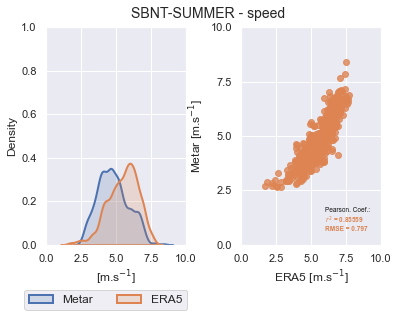

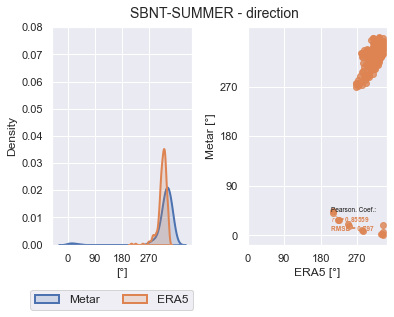

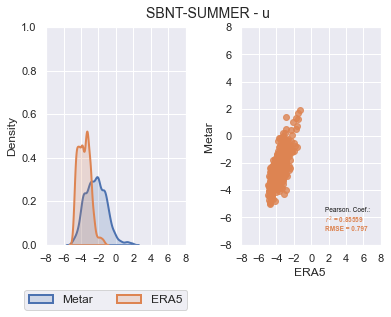

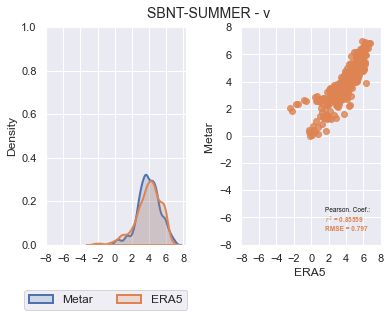

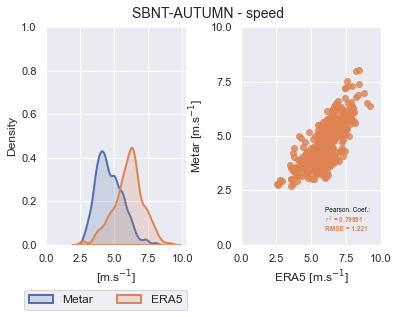

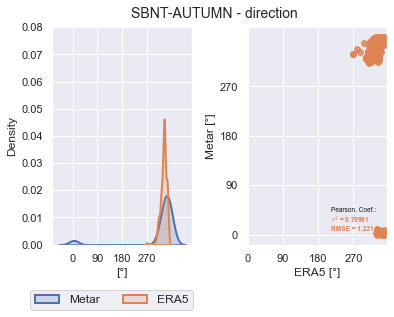

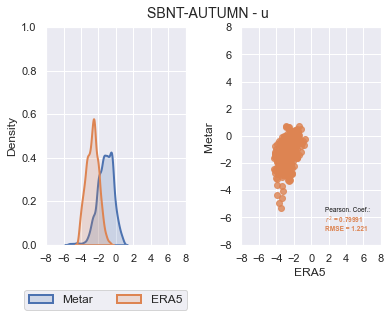

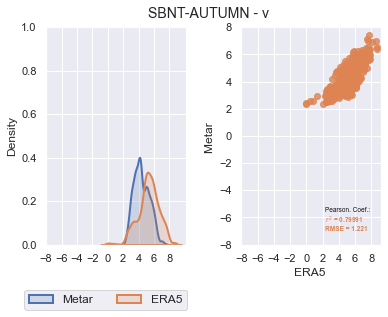

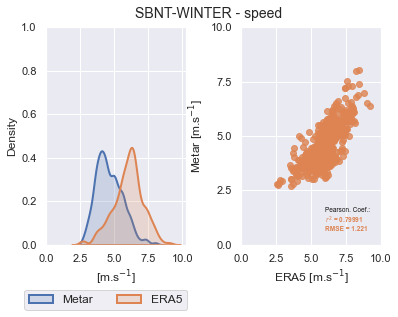

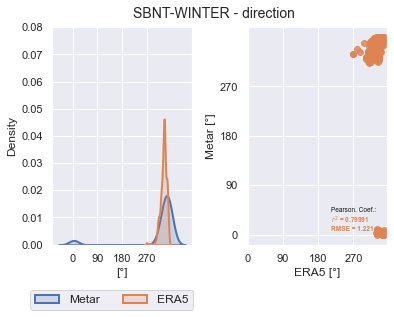

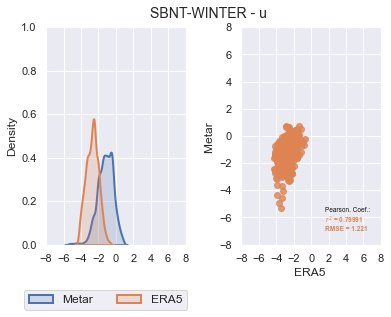

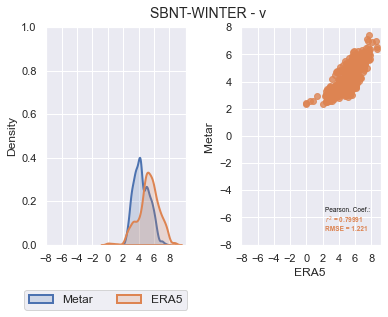

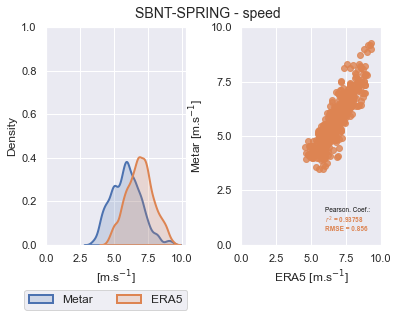

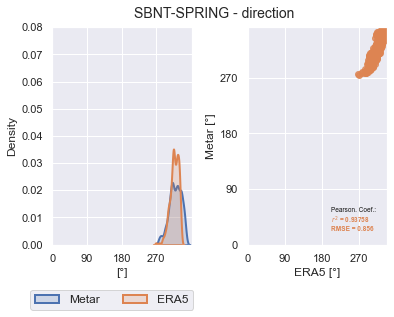

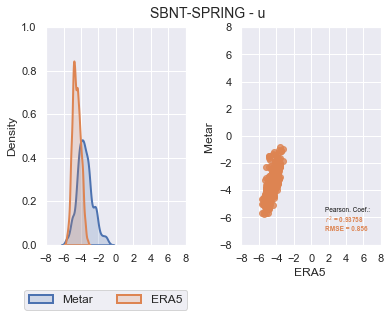

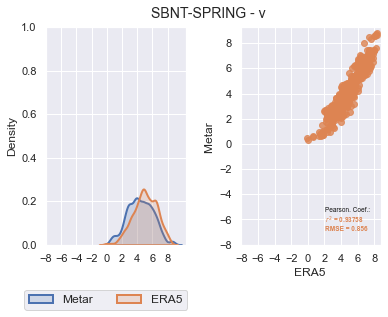

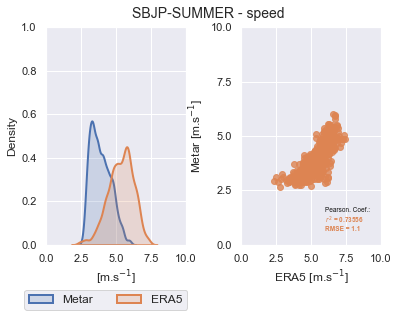

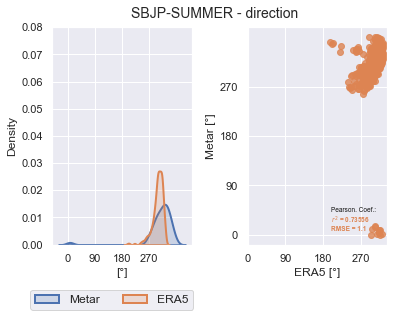

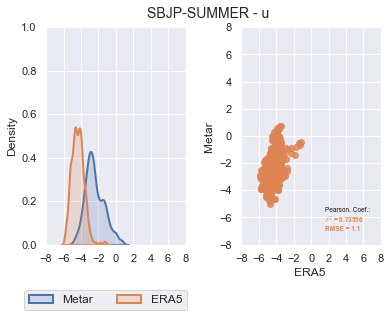

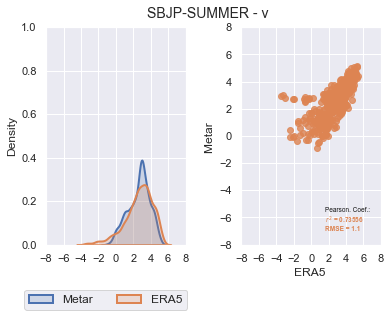

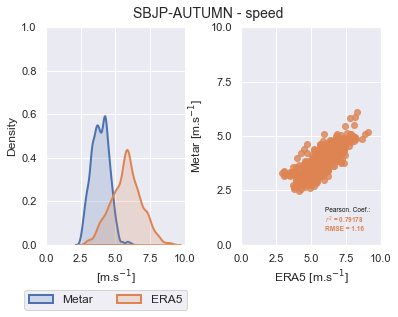

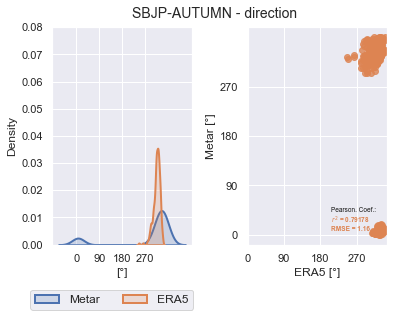

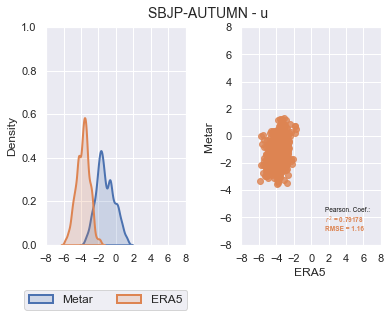

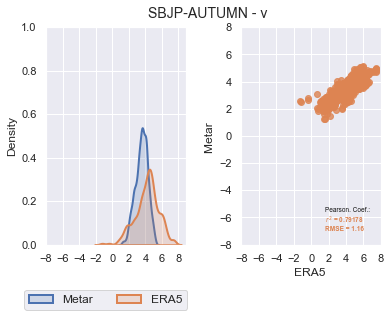

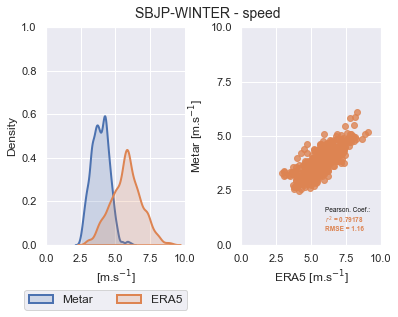

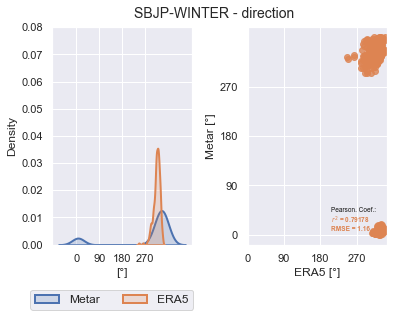

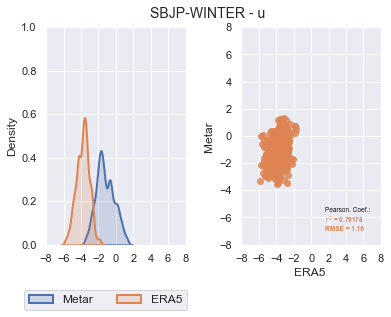

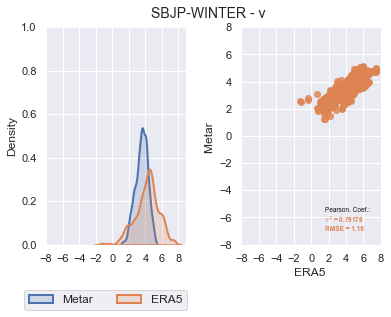

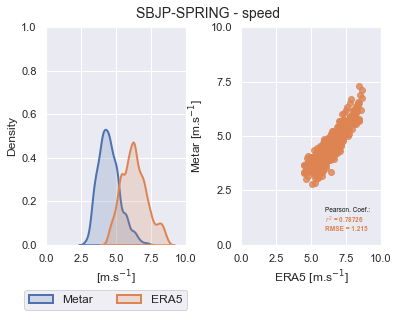

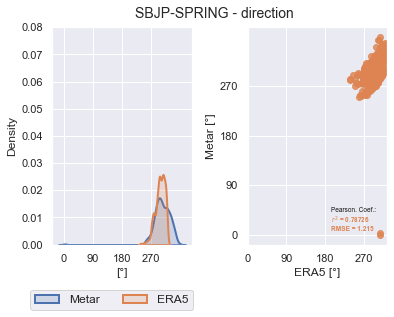

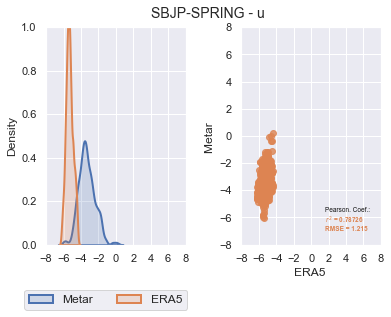

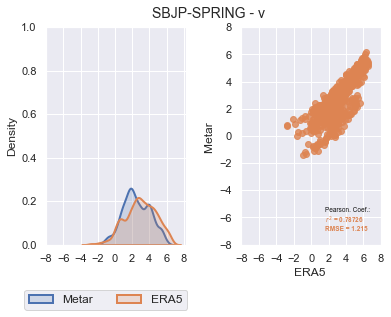

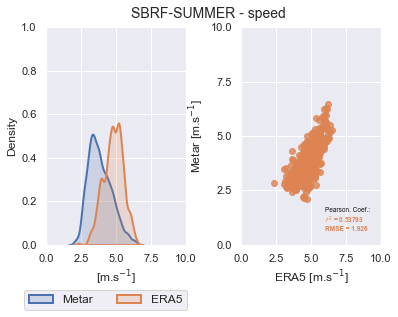

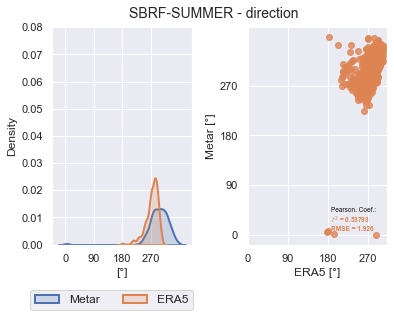

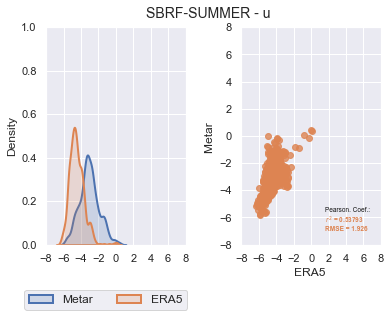

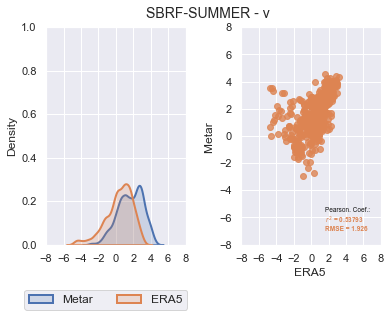

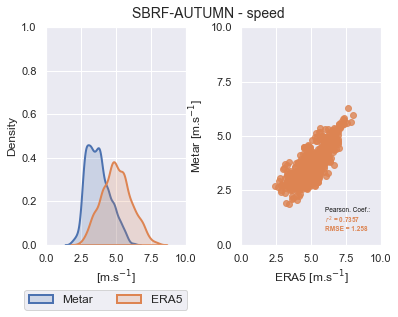

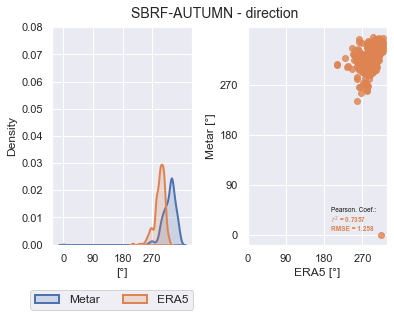

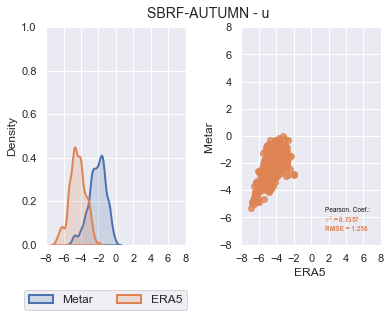

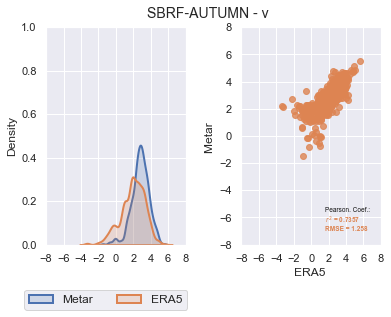

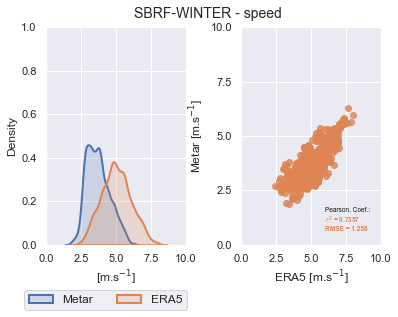

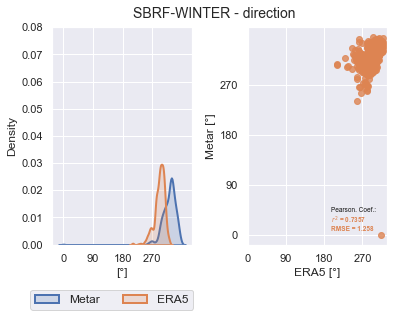

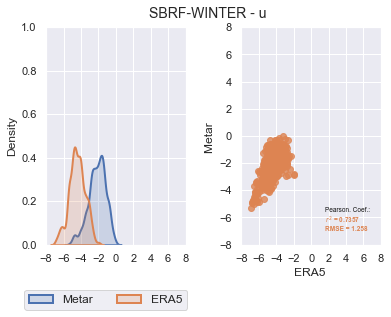

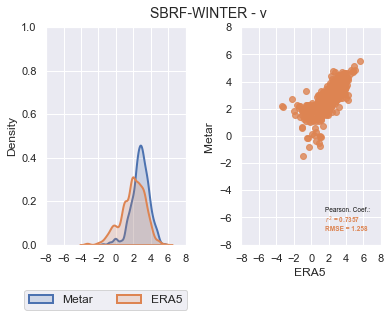

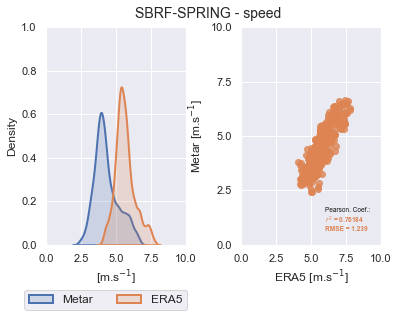

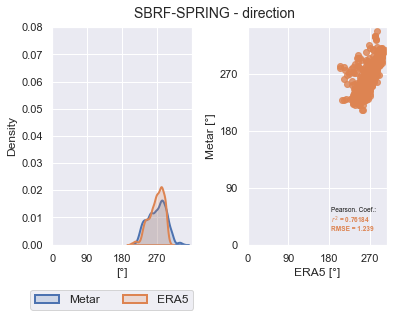

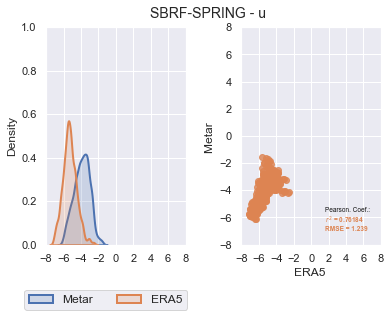

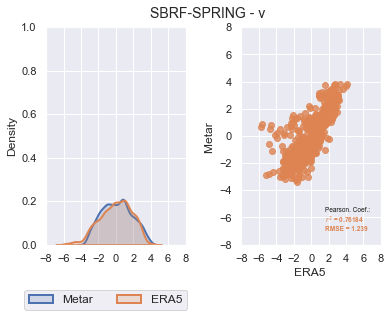

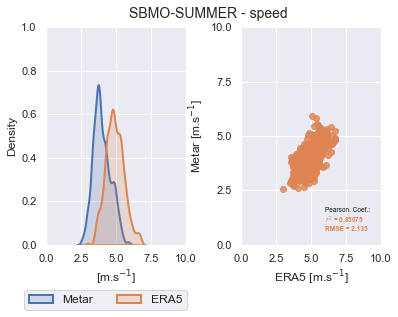

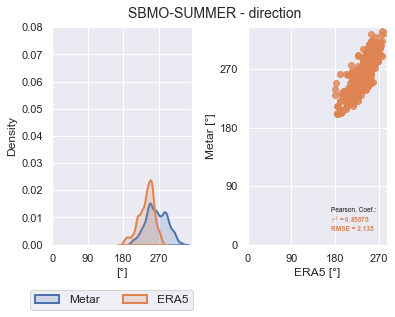

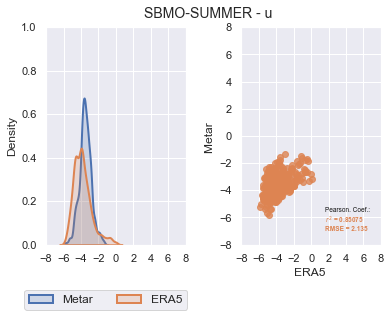

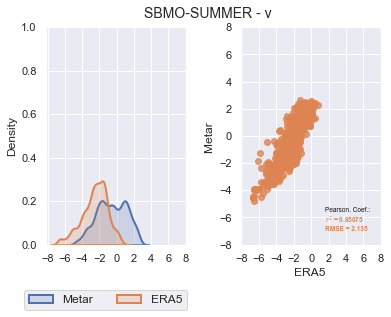

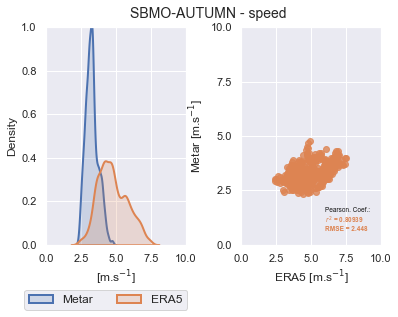

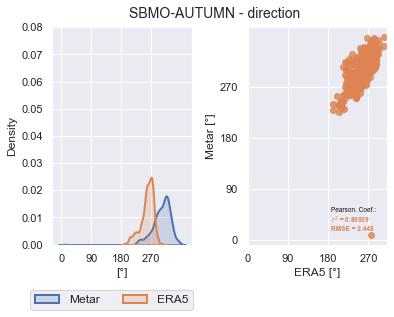

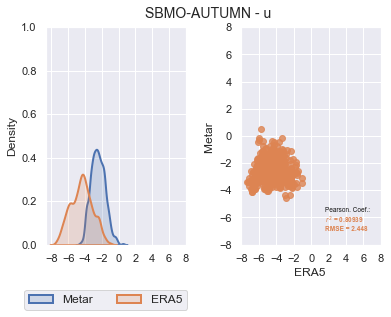

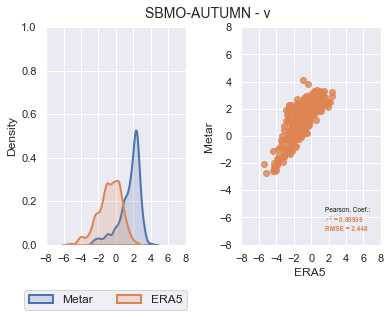

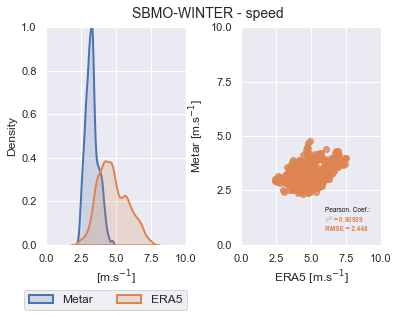

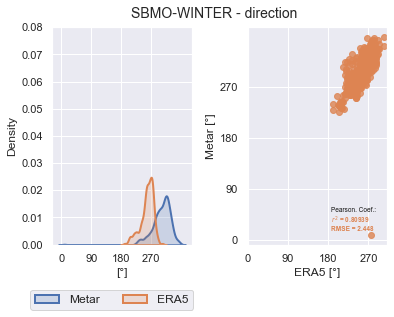

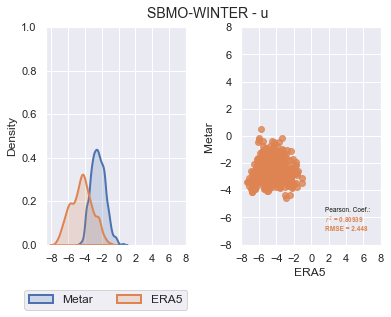

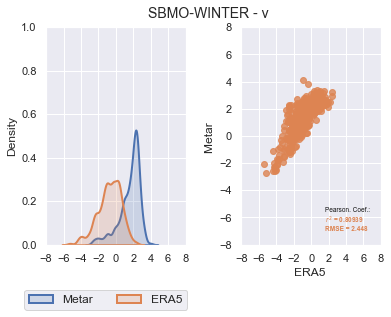

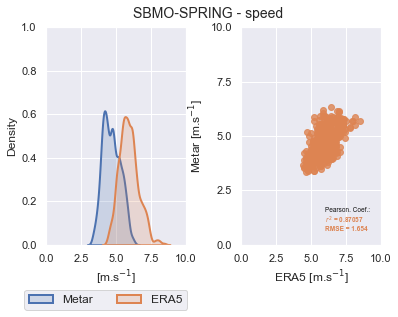

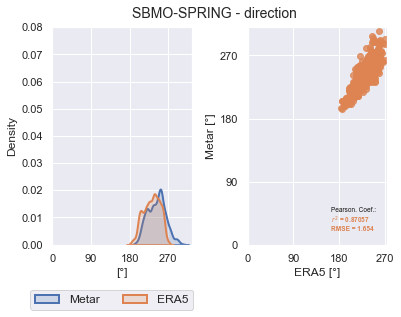

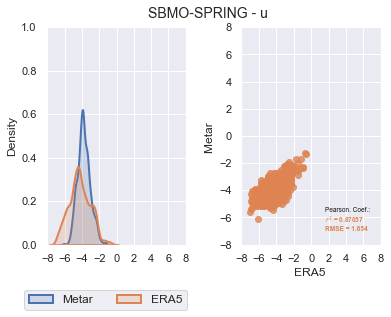

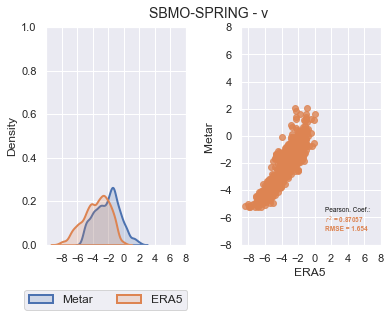

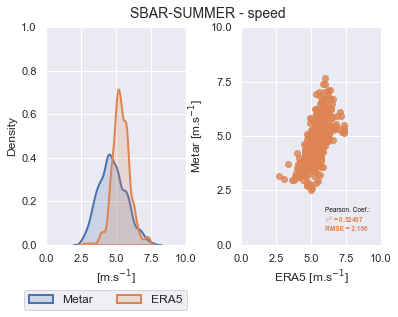

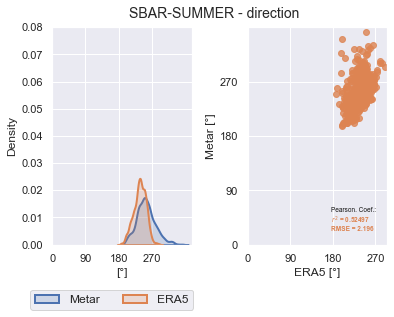

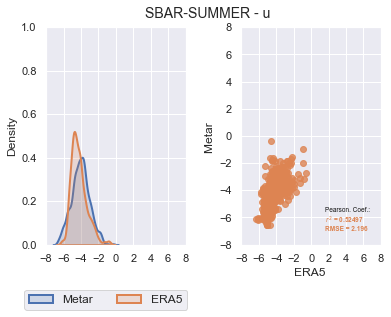

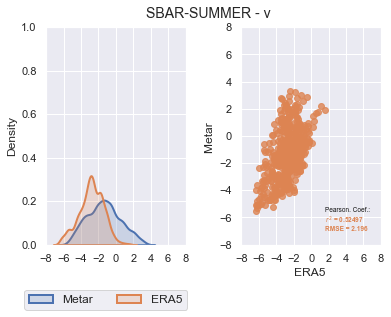

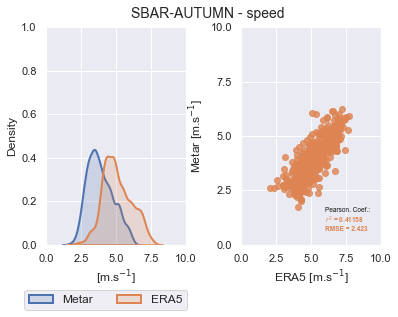

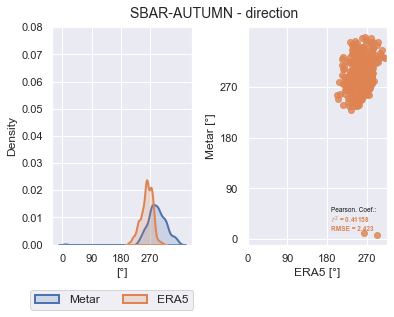

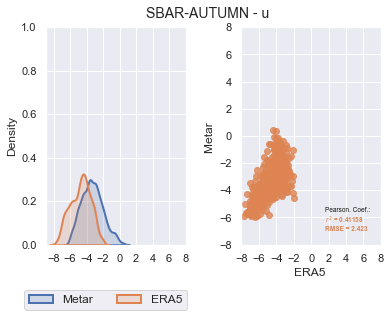

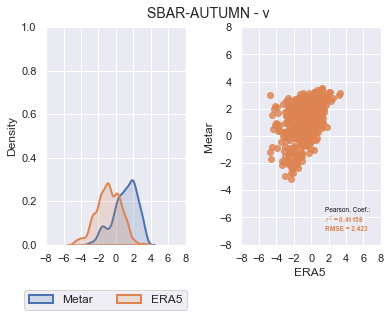

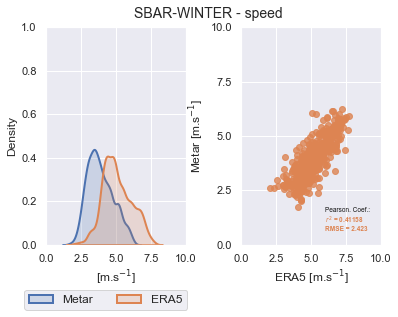

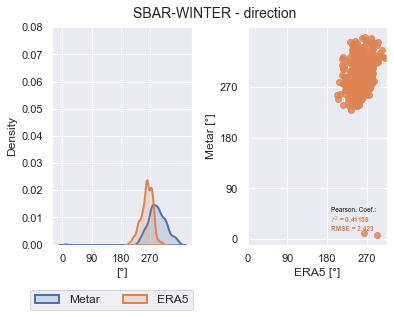

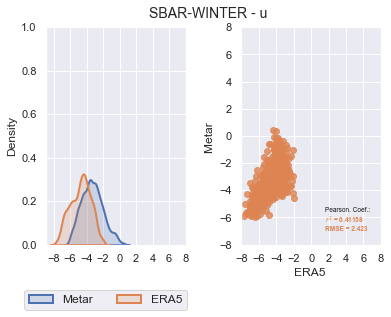

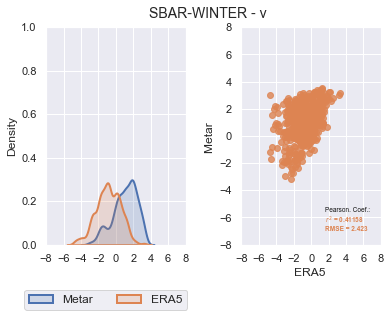

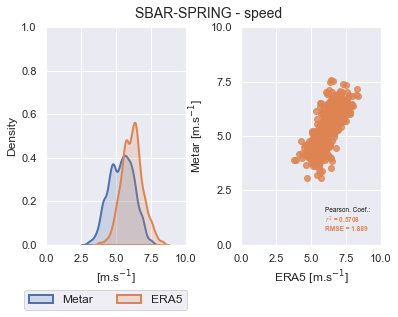

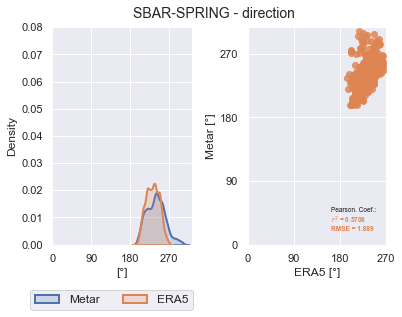

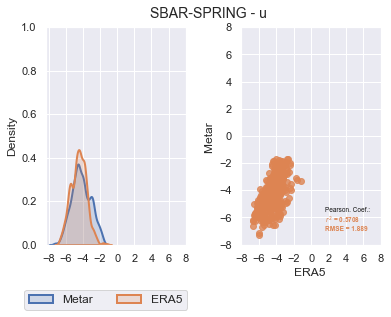

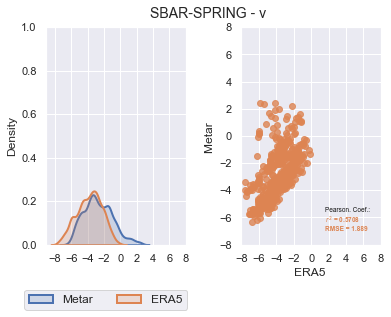

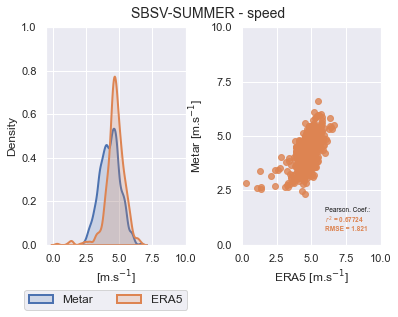

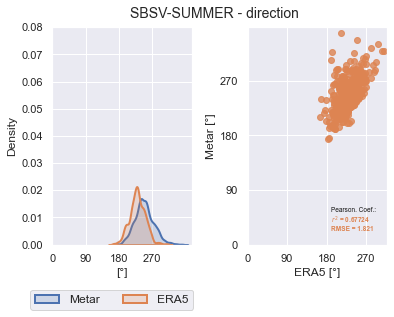

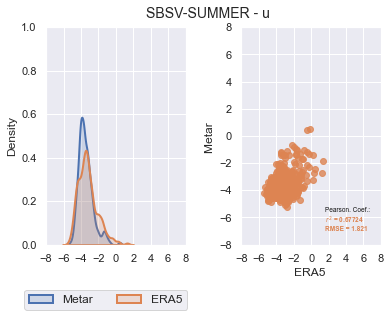

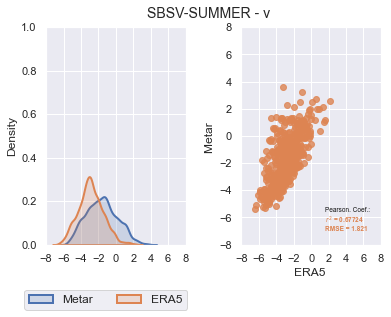

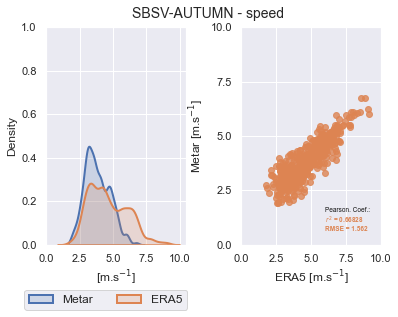

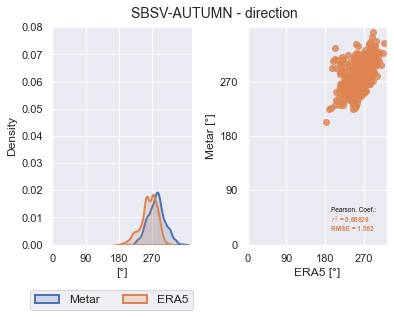

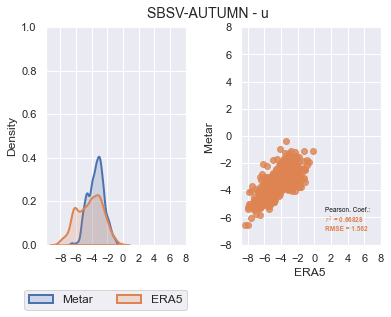

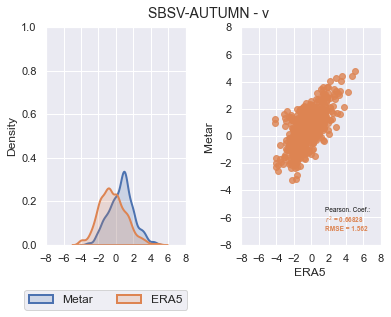

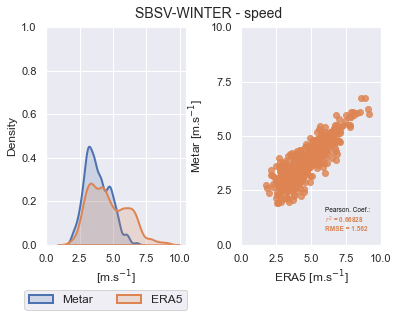

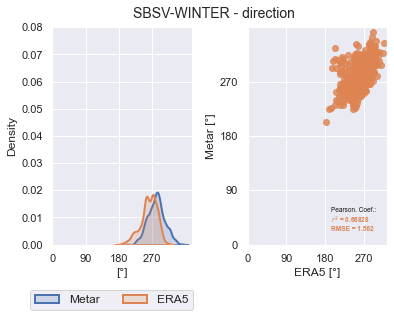

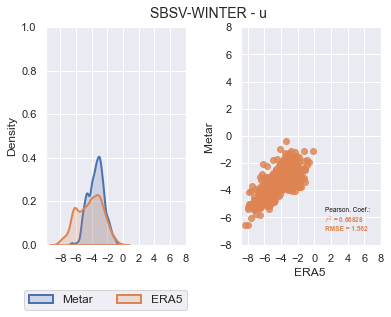

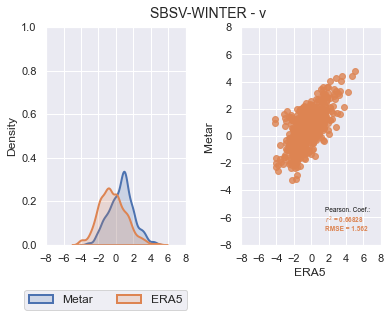

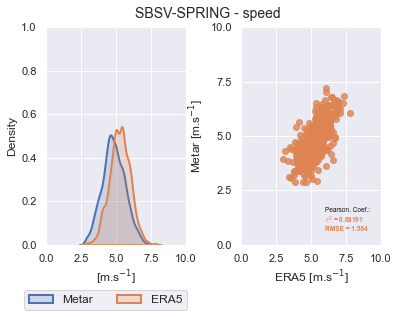

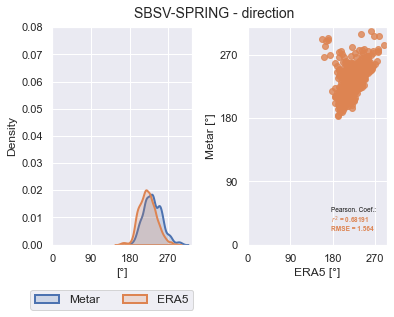

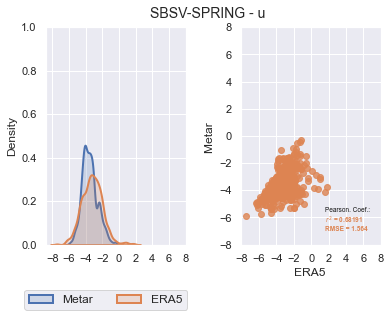

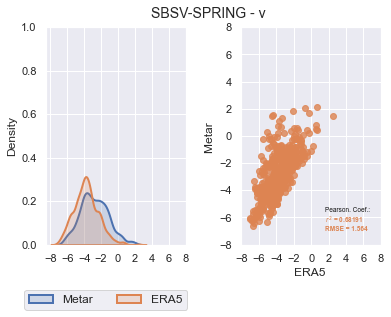

In [22]:
Season = [[1,2,3],[4,5,6],[4,5,6],[10,11,12]] #[[12,1,2],[3,4,5],[6,7,8],[9,10,11]] 
Season_names = ['SUMMER','AUTUMN','WINTER','SPRING']

''' 
FIGURA COM SeaBorn

'''
for n in names:
    for s,sn in zip(Season,Season_names):
        met_season = met[n]
        met_season = met_season[met_season.index.month.isin(s)]
        era_season = era['era_{}'.format(n)]
        era_season = era_season[era_season.index.month.isin(s)]
        
        schema = [met_season, era_season]

        f1 = open(os.path.join(path_output, './{}/'.format(n),'./Correlacoes_STATs/Stats_WND_{}_{}.txt'.format(n,sn)) , 'w')
        print('\n\t',n,sn,file=f1)

        for v in vars:
            for i in range(0,len(schema)):
                print('\n',nam[i],' - Variable: ',v,file=f1)
                print(stats.describe(schema[i][v],nan_policy='omit'), ('std= '+str(np.std(schema[i][v]))),file=f1)
        f1.close()

        f2 = open(os.path.join(path_output, './{}/'.format(n),'./Correlacoes_STATs/R2_{}_{}.txt'.format(n,sn)) , 'w')
        R = []
        RMSE = []
        for v in vars:
            for i in range(0,len(schema)-1):
                res = stats.pearsonr(x=schema[i+1][v],y=schema[0][v])
                err = rmse(schema[i+1][v],schema[0][v])
                print('\n',' - Variable: ',v,file=f2)
                print('\nPearson Corr. -', nam[i+1], nam[0],file=f2)
                print(res,file=f2)

                R.append(np.round(res[0],5))
                RMSE.append(np.round(err,3))                
        f2.close()

        ''' 
        FIGURA COM SeaBorn

        '''
        for v in vars:
            fig, [ax1,ax2] = plt.subplots(nrows=1, ncols=2, gridspec_kw={'width_ratios':[2,2], 'height_ratios':[1]})
            cmap = sns.color_palette(as_cmap=True)

            with sns.axes_style("darkgrid"):
                for i in range(0,len(schema)):
                    ax1 = sns.kdeplot(data=schema[i][v], x = schema[i][v], fill=True, alpha=.2, linewidth=2, bw=0.2, ax=ax1)

            with sns.axes_style("darkgrid"):
                for i in range(0,len(schema)-1):
                    ax2 = sns.regplot(x=schema[i+1][v], y=schema[0][v], color=cmap[i+1], fit_reg = False, ax=ax2)

            fig.subplots_adjust(wspace=0.4)
            fig.suptitle('{}-{}'.format(n,sn)+' - '+v,fontsize=14,y=.95)

            if str(v) == 'speed':
                unit = "[m.s$^{-1}$]"
                ax1.set_xticks(np.arange(0,12,2.5))
                ax2.set_xticks(np.arange(0,12,2.5))
                ax2.set_yticks(np.arange(0,12,2.5))
                ax1.set_ylim(0,1)
            elif str(v) == 'direction':
                unit = "[°]"
                ax1.set_xticks(np.arange(0,360,90))
                ax2.set_xticks(np.arange(0,360,90))
                ax2.set_yticks(np.arange(0,360,90))
                ax1.set_ylim(0,0.08)
            else:
                unit = ""
                ax1.set_xticks(np.arange(-8,10,2))
                ax2.set_xticks(np.arange(-8,10,2))
                ax2.set_yticks(np.arange(-8,10,2))
                ax1.set_ylim(0,1)

            ax1.set_xlabel(unit)
            ax2.set_xlabel('ERA5 ' + unit)
            ax2.set_ylabel('Metar ' + unit)
            
            ax1.legend(nam,fontsize=12, bbox_to_anchor = (-.2,-.18),loc='upper left', ncol=3)

            ax2.annotate('Pearson. Coef.:', fontsize=6.5,color='k',xy=(.6,.15),xycoords='axes fraction')
            ax2.annotate("$r^2$ = " + str(R[ind]), fontsize=6.5,color=cmap[1],
                        xy=(.6, .1), xycoords='axes fraction',fontweight="bold")
            ax2.annotate("RMSE = " + str(RMSE[ind]), fontsize=6.5,color=cmap[1],
                        xy=(.6, .065), xycoords='axes fraction',fontweight="bold")

            plt.savefig('D:/00_Masters/02_Resultados_Parciais/Validacao_Meteo/{}/Correlacoes_STATs/{}_{}_{}.png'.format(n,n,v,sn), format='png', dpi=300, bbox_inches='tight')
            plt.close()

#### Serie Temporal

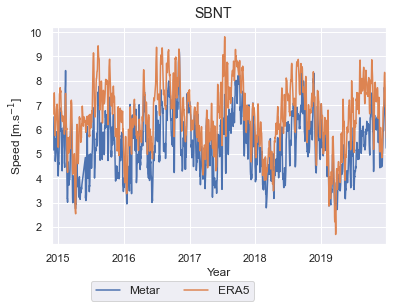

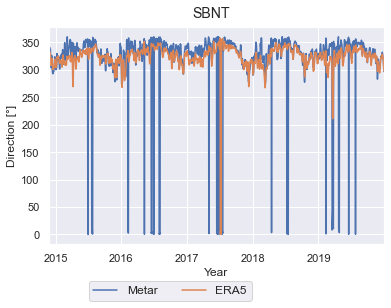

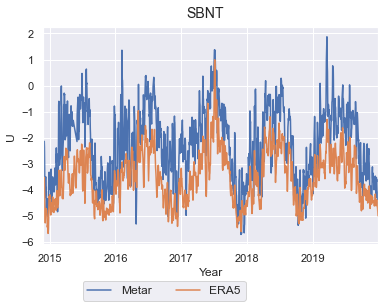

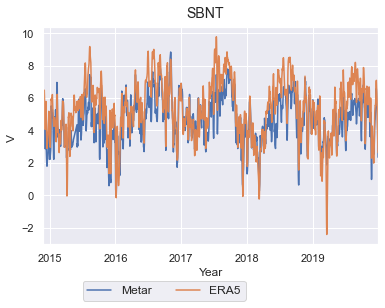

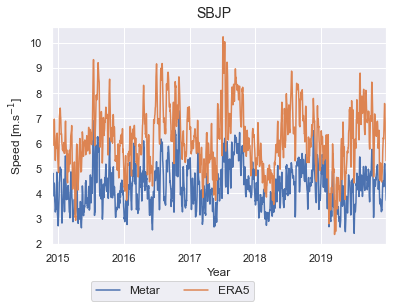

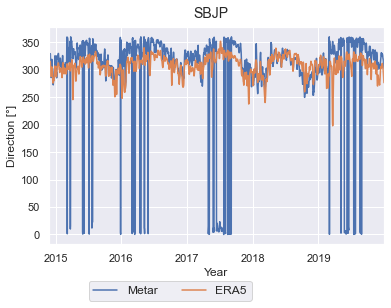

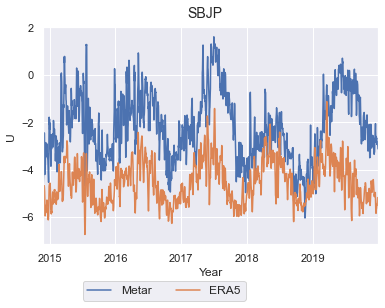

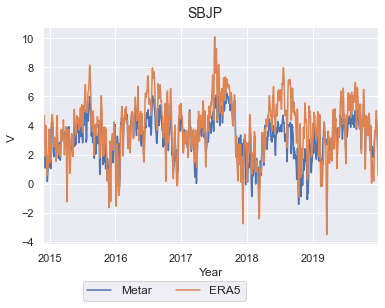

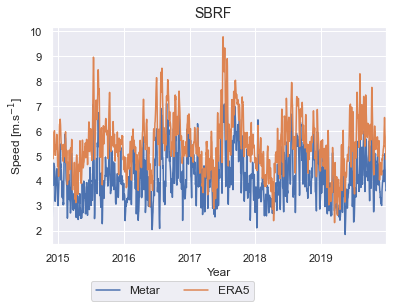

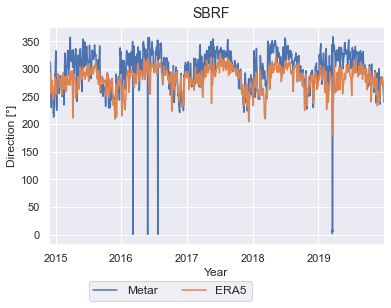

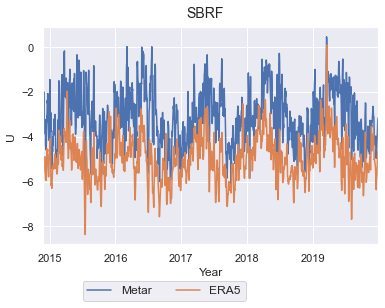

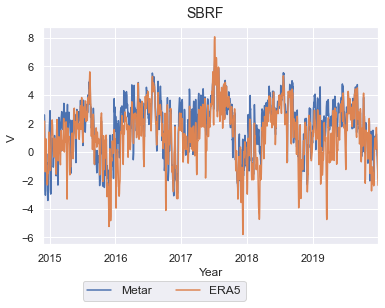

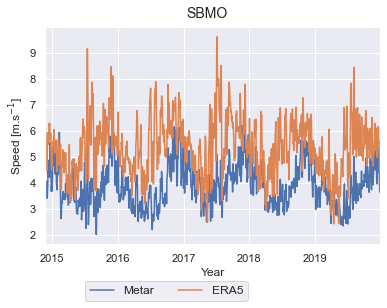

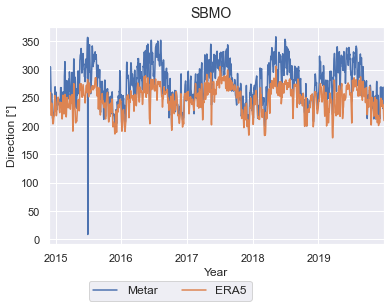

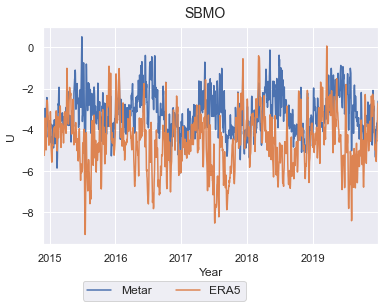

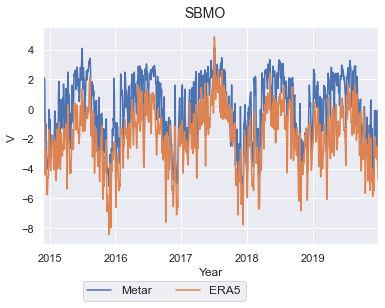

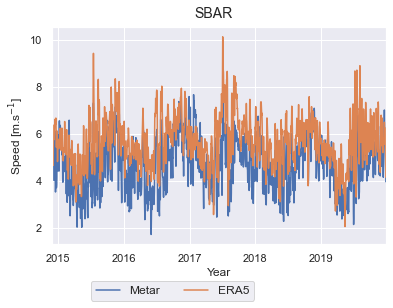

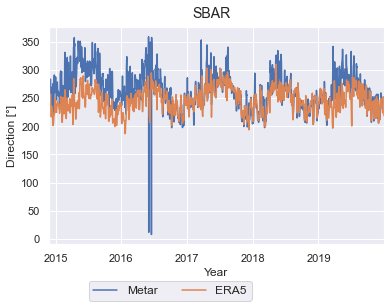

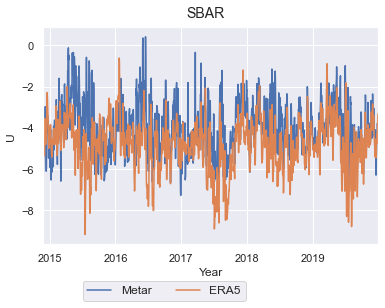

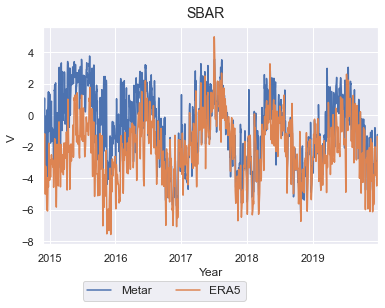

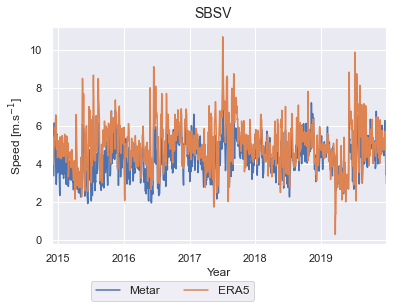

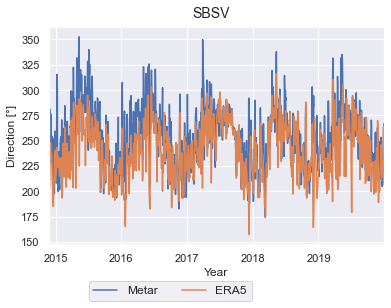

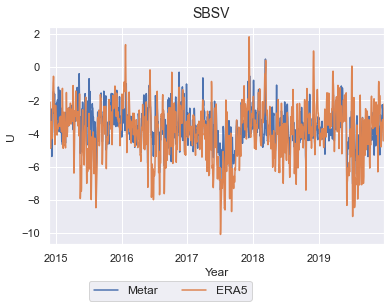

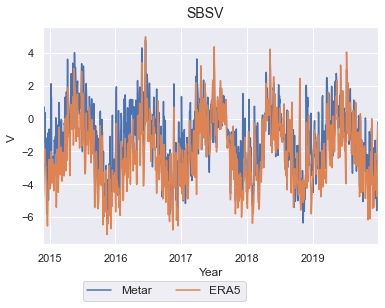

In [25]:

for n in names:
    schema = [met[n],era['era_{}'.format(n)]]

    for v in vars:
        fig, ax1 = plt.subplots(nrows=1, ncols=1, gridspec_kw={'width_ratios':[2], 'height_ratios':[1]})
        cmap = sns.color_palette(as_cmap=True)
        fig.suptitle('{}'.format(n).upper(),fontsize=14,y=.95)

        with sns.axes_style("darkgrid"):
            for i in range(0,len(schema)):
                ax1 = sns.lineplot(x=schema[i][v].index,y=schema[i][v],ax=ax1)

        ax1.autoscale(enable=True, axis='x', tight=True)
        ax1.legend(nam,fontsize=12, bbox_to_anchor = (0.1,-.14),loc='upper left', ncol=3)
        ax1.set_xlabel('Year')
        if str(v) == 'speed':
                    unit = "[m.s$^{-1}$]"
        elif str(v) == 'direction':
                    unit = "[°]"
        else:
            unit = ""
        ax1.set_ylabel('{}'.format(v).capitalize() + ' ' +unit)

        plt.savefig('D:/00_Masters/02_Resultados_Parciais/Validacao_Meteo/{}/Serie_Temporal/serie_{}_{}.png'.format(n,n,v), format='png', dpi=300, bbox_inches='tight')
        plt.close()

#### [_PENDENTE_] Plot do MAPA de localizações

In [ ]:
lat = []
lon = [] 
for n in names:
    schema = [met[n],era['era_{}'.format(n)]]
    lat.append(str(schema[1]['latitude'][0]))
    lon.append(str(schema[1]['longitude'][0]))


In [ ]:
# met[n][v].isnull().any()

TypeError: unhashable type: 'slice'

#### HistDir

refazendo dataset sem a correção para convenção oceanográfica do vento
pois a rotina HistDir já faz automaticamente essa conversão;

            ERA5

In [26]:
era = {}

for n,fi,c in zip(names,P,Coast_angle_Corr):
    varU = eval('uE_{}'.format(n)).to_dataframe()
    varU = varU.rolling(str((fi*-1//24)+1)+'D',center=True).mean()
    varU = varU.resample('1D').mean()

    varN = eval('vN_{}'.format(n)).to_dataframe()
    varN = varN.rolling(str((fi*-1//24)+1)+'D',center=True).mean()
    varN = varN.resample('1D').mean()

    erat = varU
    erat['v10'] = varN['v10']
    erat['speed'], erat['direction'] = uv2veldire(erat['u10'],erat['v10'],corr_val=c)#
    erat['u'], erat['v'] = veldire2uv(erat['speed'], erat['direction']) #Replica a coluna para caso haja correção em relação a costa e ajusta nome da coluna
    
    erat['direction'][erat['direction']<0] += 360

    era['era_{}'.format(n)] = erat


            METAR

In [27]:
met = {}

for i,n,fi,c in zip(range(0,len(names)),names,P,Coast_angle_Corr):
    ban = df_list[i].rolling(str((fi*-1//24)+1)+'D',center=True).mean()
    ban = ban.resample('1D').mean()
    ban['direction'] = ban['direction'] - c
    ban['u'],ban['v'] = veldire2uv(ban['speed'],ban['direction'])
    ban = ban.interpolate(method='linear')

    ban['direction'][ban['direction']<0] += 360

    met['{}'.format(n)] = ban

In [29]:
vars = ['speed','direction']
nam = ['Metar','ERA5']
path_output = 'D:/00_Masters/02_Resultados_Parciais/'
Season = [[1,2,3],[4,5,6],[4,5,6],[10,11,12]] #[[12,1,2],[3,4,5],[6,7,8],[9,10,11]] 

for n in names:
    schema = [met[n],era['era_{}'.format(n)]]

    for i in range(0,len(schema)):
        outputname = 'D:/00_Masters/02_Resultados_Parciais/Validacao_Meteo/{}/HistDir/'.format(n)+str(nam[i])+'_'+str(n)
        vel = schema[i]['speed']
        dire = schema[i]['direction']
        
        HistDir(P=vel,D=dire,Pmax=10,MaxProb=80,
                arqname=outputname,
                par='vento',interpolado=False, conv_oc=True)

        for s,sn in zip(Season,Season_names):
            
            schema_S = schema[i]
            schema_S = schema_S[schema_S.index.month.isin(s)]

            outputname = 'D:/00_Masters/02_Resultados_Parciais/Validacao_Meteo/{}/HistDir/'.format(n)+str(n)+'_'+str(nam[i])+'_'+'_'+sn
        
            HistDir(P=schema_S['speed'],D=schema_S['direction'],Pmax=10,MaxProb=80,
                    arqname=outputname,
                    par='vento',interpolado=False, conv_oc=True)

            print(str(n)+'_'+str(nam[i])+'_'+'_'+sn)

Done
Done
SBNT_Metar__SUMMER
Done
SBNT_Metar__AUTUMN
Done
SBNT_Metar__WINTER
Done
SBNT_Metar__SPRING
Done
Done
SBNT_ERA5__SUMMER
Done
SBNT_ERA5__AUTUMN
Done
SBNT_ERA5__WINTER
Done
SBNT_ERA5__SPRING
Done
Done
SBJP_Metar__SUMMER
Done
SBJP_Metar__AUTUMN
Done
SBJP_Metar__WINTER
Done
SBJP_Metar__SPRING
Done
Done
SBJP_ERA5__SUMMER
Done
SBJP_ERA5__AUTUMN
Done
SBJP_ERA5__WINTER
Done
SBJP_ERA5__SPRING
Done
Done
SBRF_Metar__SUMMER
Done
SBRF_Metar__AUTUMN
Done
SBRF_Metar__WINTER
Done
SBRF_Metar__SPRING
Done
Done
SBRF_ERA5__SUMMER
Done
SBRF_ERA5__AUTUMN
Done
SBRF_ERA5__WINTER
Done
SBRF_ERA5__SPRING
Done
Done
SBMO_Metar__SUMMER
Done
SBMO_Metar__AUTUMN
Done
SBMO_Metar__WINTER
Done
SBMO_Metar__SPRING
Done
Done
SBMO_ERA5__SUMMER
Done
SBMO_ERA5__AUTUMN
Done
SBMO_ERA5__WINTER
Done
SBMO_ERA5__SPRING
Done
Done
SBAR_Metar__SUMMER
Done
SBAR_Metar__AUTUMN
Done
SBAR_Metar__WINTER
Done
SBAR_Metar__SPRING
Done
Done
SBAR_ERA5__SUMMER
Done
SBAR_ERA5__AUTUMN
Done
SBAR_ERA5__WINTER
Done
SBAR_ERA5__SPRING
Done
Done
